In [1]:
# pip freeze | xargs pip uninstall -y

In [2]:
import numpy as np
import nolds
from scipy import interpolate
from scipy import signal
import pandas as pd
import matplotlib.patches as mpatches
from collections import OrderedDict
from matplotlib import style
import matplotlib.pyplot as plt
import pylab as plot
from astropy.stats import LombScargle
style.use('ggplot')
params = {'legend.fontsize': 20,
          'legend.handlelength': 2,
         'axes.titlesize' : 20,
          'axes.labelsize' : 10,
          'lines.linewidth' : 2,
          'lines.markersize' : 5,
          'xtick.labelsize' : 15,
          'ytick.labelsize' : 15}
plot.rcParams.update(params)

In [3]:
import json

# Load data example 
with open('data_example/2b3d7a98-a1fb-47ad-9705-4a91d448da9b_RrInterval_2018-07-03T160210842.json') as f:
    data = json.load(f)

import pandas as pd

data_field = data["data"]
# Split fields in timestamp & value
df_exploration = pd.DataFrame(list(map(lambda x: x.split(" "), data_field)), 
                              columns= ["timestamp", "RrInterval"])

# Cast value as int
df_exploration["RrInterval"] = df_exploration["RrInterval"].apply(lambda x : int(x))

# set cleaned timestamp as index
df_exploration["timestamp"] = pd.to_datetime(df_exploration["timestamp"])
df_exploration = df_exploration.set_index("timestamp")

df_exploration.sample(10)

,RrInterval
timestamp,
2018-07-03 16:05:42.945,745
2018-07-03 16:16:17.605,782
2018-07-03 16:13:22.608,775
2018-07-03 16:06:47.728,743
2018-07-03 16:03:05.450,712
2018-07-03 16:11:42.659,653
2018-07-03 16:16:19.554,724
2018-07-03 16:02:32.784,789
2018-07-03 16:07:34.523,684


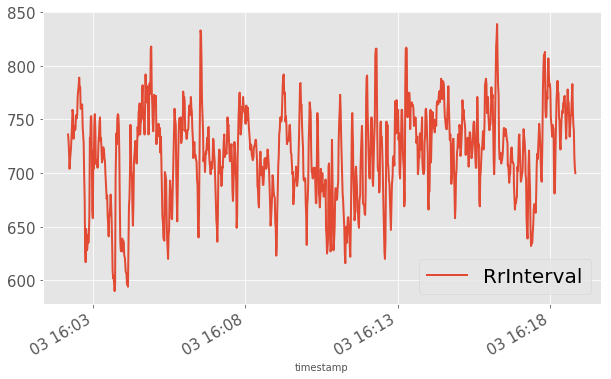

In [4]:
df_exploration.plot(figsize=(10,6))

# Pre processing to clean Outliers
> To Do / En cours

In [5]:
def clean_outlier_v1(RrIntervals, method = "Malik", custom_rule = None):
    """
    RR intervals differing by more than the removing_rule from the one 
    proceeding it are removed.

    Arguments
    ---------
    RrIntervals - list of Rr Intervals
    method - method to use to clean outlier. Malik, Kamath or Custom
    custom_rule - percentage criteria of difference with previous Rr
    Interval at which we consider that it is abnormal
    
    Returns
    ---------
    NNIntervals - list of NN Interval

    """
    
    RrIntervals = np.array(RrIntervals)
    # Conversion Heart rate (beat per min) to RrInterval (ms) : 
    # RrI = Hr / 60 x 1000
    #RrIntervals = np.where(RrInterval > 2000, np.nan, RrInterval)
    #RrIntervals = np.where(RrInterval < (30*1000/60), np.nan, RrInterval)
    
    # set first element in list
    NNIntervals = [RrIntervals[0]]
    outlier_count = 0
    previous_outlier = False
    j = 0
    for i, RrInterval in enumerate(RrIntervals[:-1]):
        
        if previous_outlier:
            # TO DO re tester si ectopic beat 
            NNIntervals.append(RrIntervals[i+1])
            previous_outlier = False
            continue
        # TO DO pour v2 ... Check si plusieurs outliers consécutifs. Quelle règle appliquer ? 
        #while previous_outlier:
         #   j += 1
          #  if is_outlier(RrInterval, RrIntervals[i+1+j]):
           #     NNIntervals.append(np.nan)
            #    continue
            #else:
             #    previous_outlier = False
            
        if is_outlier(RrInterval, RrIntervals[i+1], method, custom_rule):
            NNIntervals.append(RrIntervals[i+1])
        else:
            # A débattre, Comment remplacer les outliers ?
            NNIntervals.append(np.nan)
            outlier_count += 1
            previous_outlier = True
    print("Il y a {} outliers supprimés".format(outlier_count))
    
    return NNIntervals

def is_outlier(RrInterval, next_RrInterval, method = "Malik", custom_rule=None):
    if method == "Malik":
        return abs(RrInterval - next_RrInterval) <= 0.2 * RrInterval
    elif method == "Kamath":
        return 0 <= (next_RrInterval - RrInterval) <= 0.325 * RrInterval or  0 <= (RrInterval - next_RrInterval) <= 0.245 * RrInterval
    elif method == "custom":
        return  abs(RrInterval - next_RrInterval) <= custom_rule * RrInterval
    else:
        raise ValueError("Not a valid method. Please choose Malik or Kamath")
        
def test_sample(NnIntervals, outlier_count):
    if outlier_count / len(NnIntervals) > 0.2 :
        print("Too much outlier for analyses !")
    if len(NnIntervals) < 240:
        print("Not enough Heart beat for Nyquist criteria !")
    return None

In [6]:
testNN = [100, 120, 100, 135, 100, 90, 100, 120, 100, 111, 100, 79, 100, 75, 100, 140]
print(clean_outlier_v1(testNN, method="Kamath"))
print(clean_outlier_v1(testNN, method="Malik"))
print(clean_outlier_v1(testNN, "custom", 0.1))

Il y a 3 outliers supprimés
[100, 120, 100, nan, 100, 90, 100, 120, 100, 111, 100, 79, 100, nan, 100, nan]
Il y a 4 outliers supprimés
[100, 120, 100, nan, 100, 90, 100, 120, 100, 111, 100, nan, 100, nan, 100, nan]
Il y a 7 outliers supprimés
[100, nan, 100, nan, 100, 90, nan, 120, nan, 111, 100, nan, 100, nan, 100, nan]


In [7]:
testNN2 = [100, 100, 100, 140, 60, 100, 100]
testNN3 =  [100, 100, 100, 140, 140, 40, 100, 100]
print(clean_outlier_v1(testNN2))
print(clean_outlier_v1(testNN3))

Il y a 2 outliers supprimés
[100, 100, 100, nan, 60, nan, 100]
Il y a 2 outliers supprimés
[100, 100, 100, nan, 140, nan, 100, 100]


In [8]:
NNIntervals = clean_outlier_v1(df_exploration["RrInterval"])

print(NNIntervals[:10])

Il y a 0 outliers supprimés
[736, 730, 719, 704, 712, 718, 724, 734, 744, 759]


# Time Domain Features

In [9]:
def get_time_domain_features(NNIntervals):
    """
    Function returning a dictionnary containing time domain features for 
    HRV analyses.

    Mostly used on Long term recordings (24h) but some studies use this 
    features on short term recordings, from 2 to 5 minutes window.
    
    Arguments
    ----------
    NNIntervals - list of Normal to Normal Interval
    
    Returns
    ----------
    timeDomainFeaturess - dictionnary containing time domain features for 
    HRV analyses. Thera are details about each features below.
    
    Notes
    ----------
    Details about feature engineering...
    
    - **meanNN**: The the mean RR interval
    
    - **SDNN**: The standard deviation of the time interval between successive normal heart 
    beats (*i.e.*, the RR intervals)
    
    - **SDSD**: Standard deviation of differences between adjacent NN intervals
    
    - **RMSSD**: The square root of the mean of the sum of the squares of differences between
    adjacent NN intervals. Reflects high frequency (fast or parasympathetic) influences on HRV 
    (*i.e.*, those influencing larger changes from one beat to the next).
    
    - **medianNN**: Median Absolute values of the successive Differences between the RR intervals.

    - **NN50**: Number of interval differences of successive RR intervals greater than 50 ms.

    - **pNN50**: The proportion derived by dividing NN50 (The number of interval differences of 
    successive RR intervals greater than 50 ms) by the total number of RR intervals.

    - **NN20**: Number of interval differences of successive RR intervals greater than 20 ms.

    - **pNN20**: The proportion derived by dividing NN20 (The number of interval differences of 
    successive RR intervals greater than 20 ms) by the total number of RR intervals.

    - **CVSD**: The coefficient of variation of successive differences (van Dellen et al., 1985), 
    the RMSSD divided by meanNN.
    
    - **RangeNN**: différence between the maximum and minimum NNInterval.
    
    
    References
    ----------
    TO DO
    
    """
    
    diff_nni = np.diff(NNIntervals)
    L = len(NNIntervals)
    
    meanNN = np.mean(NNIntervals)
    SDNN = np.std(NNIntervals, ddof=1) # ddof = 1 : estimateur non biaisé => divise std par n-1
    SDSD = np.std(diff_nni)
    RMSSD = np.sqrt(np.mean(diff_nni ** 2))
    medianNN = np.median(NNIntervals)
    
    NN50 = sum(abs(diff_nni) > 50)
    pNN50 = 100 * NN50 / L
    NN20 = sum(abs(diff_nni) > 20)
    pNN20 = 100 * NN20 / L
    
    RangeNN = max(NNIntervals) - min(NNIntervals)
    
    # Feature(s) trouvée(s) sur les codes github et non dans la doc
    #CVSD = RMMSD / meanNN
    
    # Features non calculables pour short term recordings
    #SDNN équivaut à SDANN sur 24h et non sur une fenêtre temporelle
    #cvNN = SDNN / meanNN # Necissite cycle 24h
    
    timeDomainFeaturess = {
        'meanNN': meanNN, 
        'SDNN': SDNN, 
        'SDSD': SDSD, 
        'NN50': NN50,
        'pNN50' : pNN50, 
        'NN20' : NN20, 
        'pNN20' : pNN20, 
        'RMSSD' : RMSSD,
        'MedianNN' : medianNN, 
        'RangeNN' : RangeNN
        #,'CVSD' : CVSD,
        #'SDNN' : SDNN,
        #'cvNN' : cvNN
        
    }
    
    return timeDomainFeaturess

# TO DO
# GEOMETRICAL FEATURES

In [10]:
get_time_domain_features(NNIntervals)

{'meanNN': 718.248,
 'SDNN': 43.113074968427306,
 'SDSD': 19.519367520775713,
 'NN50': 24,
 'pNN50': 2.4,
 'NN20': 225,
 'pNN20': 22.5,
 'RMSSD': 19.519400785039664,
 'MedianNN': 722.5,
 'RangeNN': 249}

# Frequency Domain Features

In [11]:
def get_frequency_domain_features(NNIntervals, method = "Welch", sampling_frequency = 7, 
                                  interpolation_method = "linear", VLF_band = [0.0033, 0.04], 
                                  LF_band = [0.04, 0.15], HF_band = [0.15, 0.40], plot = 0):
    
    """
    Function returning a dictionnary containing frequency domain features 
    for HRV analyses.
    Must use this function on short term recordings, from 2 to 5 minutes 
    window.
    
    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval
    method - Method used to calculate the PSD. Choice are Welch's, Lomb and Fourier's method.
    sampling_frequency - frequence at which the signal is sampled. Common value range from 
    1 Hz to 10 Hz, by default set to 7 Hz. No need to specify if Lomb method is used.
    interpolation_method - kind of interpolation as a string, by default "linear". No need to 
    specify if Lomb method is used
    VLF_band - Very low frequency band for features extraction from power spectral density
    LF_band - Low frequency band for features extraction from power spectral density
    HF_band - High frequency band for features extraction from power spectral density
    
    Returns
    ---------
    freqency_domain_features - dictionnary containing frequency domain features 
    for HRV analyses. Thera are details about each features are given in 
    "get_features_from_PSD" function.
    
    References
    ----------
    TO DO
    """
    
    timestamps = create_time_info(NNIntervals)

    # ---------- Interpolation du signal ---------- #
    if method == "Welch":
        function = interpolate.interp1d(x = timestamps, y = NNIntervals, 
                                 kind = interpolation_method)

        timestamps_interpolation = create_interpolation_time(NNIntervals, sampling_frequency)
        NNI_interpolation = function(timestamps_interpolation)
        
        # ---------- Remove DC Component ---------- #
        NNI_normalized = NNI_interpolation - np.mean(NNI_interpolation)
    
    #  ----------  Calcul PSD  ---------- #
    # Describes the distribution of power into frequency components composing that signal.
    if method == "Welch":
        freq, PSD = signal.welch(x = NNI_normalized, fs = sampling_frequency, window = 'hann')
    
    elif method == "Lomb":
        freq, PSD = LombScargle(timestamps, NNIntervals, normalization='psd').autopower(minimum_frequency=VLF_band[0], 
                                                                                        maximum_frequency=HF_band[1])
    elif method == "Fourier":
        freq, PSD = fourier_periodogram(timestamps, NNIntervals)
    else:
        raise ValueError("Not a valid method. Choose between 'Lomb' and 'Welch'")
        
    # ----------  Calcul des features  ---------- #
    freqency_domain_features = get_features_from_PSD(freq = freq, PSD = PSD,
                                                     VLF_band = VLF_band,
                                                     LF_band = LF_band,
                                                     HF_band = HF_band)
    
    # TO DO 
    # Plotting options
    if plot == 1:
        pass
    
    return freqency_domain_features

def create_time_info(NNIntervals):
    """
    Function creating time interval of all NNIntervals
    
    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval
    
    Returns
    ---------
    NNI_tmstp - time interval between first NN Interval and final NN Interval
    """
    # Convert in seconds
    NNI_tmstp = np.cumsum(NNIntervals) / 1000.0 
    
    # Force to start at 0
    return NNI_tmstp - NNI_tmstp[0]

def create_interpolation_time(NNIntervals, sampling_frequency = 7):
    """
    Function creating the interpolation time used for Fourier transform's method
    
    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval
    sampling_frequency - frequence at which the signal is sampled
    
    Returns
    ---------
    NNI_interpolation_tmstp - timestamp for interpolation
    """
    time_NNI = create_time_info(NNIntervals)
    # Create timestamp for interpolation
    NNI_interpolation_tmstp = np.arange(0, time_NNI[-1], 1 / float(sampling_frequency))
    return NNI_interpolation_tmstp


def fourier_periodogram(t, y):
    """
    TO DO
    """
    N = len(t)
    # Return the Discrete Fourier Transform sample frequencies
    frequency = np.fft.fftfreq(N, t[1] - t[0])
    # Compute the one-dimensional discrete Fourier Transform
    y_fft = np.fft.fft(y)
    positive = (frequency > 0)
    return frequency[positive], (1. / N) * abs(y_fft[positive]) ** 2


def get_features_from_PSD(freq, PSD, VLF_band = [0.003, 0.04], 
                              LF_band = [0.04, 0.15], 
                              HF_band = [0.15, 0.40]): #, ULF_band):
    """
    Function computing frequency domain features from the power spectral 
    decomposition.
    
    Arguments
    ---------
    freq - Array of sample frequencies
    PSD - Power spectral density or power spectrum
    
    Returns
    ---------
    freqency_domain_features - dictionnary containing frequency domain features 
    for HRV analyses. Thera are details about each features are given below. 

    Notes
    ---------
    Details about feature engineering...
    
    - **total_power** : Total power density spectra
    
    - **VLF** : variance ( = power ) in HRV in the Very Low Frequency (.003 to .04 Hz by
    default). Reflect an intrinsic rhythm produced by the heart which is modulated primarily by 
    sympathetic activity.
    
    - **LF** : variance ( = power ) in HRV in the Low Frequency (.04 to .15 Hz). Reflects a 
    mixture of sympathetic and parasympathetic activity, but in long-term recordings like ours, 
    it reflects sympathetic activity and can be reduced by the beta-adrenergic antagonist propanolol
    
    - **HF**: variance ( = power ) in HRV in the High Frequency (.15 to .40 Hz by default). 
    Reflects fast changes in beat-to-beat variability due to parasympathetic (vagal) activity. 
    Sometimes called the respiratory band because it corresponds to HRV changes related to the 
    respiratory cycle and can be increased by slow, deep breathing (about 6 or 7 breaths per 
    minute) and decreased by anticholinergic drugs or vagal blockade.
    
    - **LF_HF_ratio** : LF/HF ratio is sometimes used by some investigators as a quantitative mirror 
    of the sympatho/vagal balance.
    
    - **LFnu** : normalized LF power
    
    - **HFnu** : normalized HF power
    
    References
    ---------
    TO DO
    
    """
    
    # Calcul des indices selon les bandes de fréquences souhaitées
    VLF_indexes = np.logical_and(freq >= VLF_band[0], freq < VLF_band[1])
    LF_indexes = np.logical_and(freq >= LF_band[0], freq < LF_band[1])
    HF_indexes = np.logical_and(freq >= HF_band[0], freq < HF_band[1])

    # STANDARDS

    # Integrate using the composite trapezoidal rule
    LF = np.trapz(y=PSD[LF_indexes], x=freq[LF_indexes])
    HF = np.trapz(y=PSD[HF_indexes], x=freq[HF_indexes])

    # total power & VLF : Feature utilisée plus souvent dans les analyses 
    # "Long term recordings"
    VLF = np.trapz(y=PSD[VLF_indexes], x=freq[VLF_indexes])
    total_power = VLF + LF + HF

    # Features non calculables pour "short term recordings"
    #ULF = np.trapz(y=PSD[ULF_indexes], x=freq[ULF_indexes])
    
    LF_HR_ratio = LF / HF
    LFnu = (LF / (LF + HF)) * 100
    HFnu = (HF / (LF + HF)) * 100

    # Feature(s) trouvée(s) sur les codes github et non dans la doc
    #LF_P_ratio = LF / total_power
    #HF_P_ratio = HF/ total_power

    freqency_domain_features = {
        'LF' : LF,
        'HF' : HF,
        'LF_HR_ratio' : LF_HR_ratio,
        'LFnu' : LFnu,
        'HFnu' : HFnu,
        'total_power' : total_power,
        'VLF' : VLF
        #,'ULF' : ULF,
        #'LF_P_ratio' : LF_P_ratio,
        #'HF_P_ratio' : HF_P_ratio
    }
    
    return freqency_domain_features

In [12]:
print()
print("> Lomb")
print(get_frequency_domain_features(NNIntervals, method='Lomb'))
print("--------------------------")
print("> Fourier")
print(get_frequency_domain_features(NNIntervals, method='Fourier'))

print("--------------------------")
for i in range(1,8):
    print("fs = {}".format(i))
    print("> Welch's linear")
    print(get_frequency_domain_features(NNIntervals=NNIntervals, 
                                        sampling_frequency=i,
                                       interpolation_method = "linear"))
    print()
    print("> Welch's cubic")
    print(get_frequency_domain_features(NNIntervals=NNIntervals, 
                                        sampling_frequency=i,
                                       interpolation_method = "cubic"))
    print("--------------------------")


> Lomb
{'LF': 404.06451387086076, 'HF': 140.86091659849012, 'LF_HR_ratio': 2.8685353157441535, 'LFnu': 74.15042339331367, 'HFnu': 25.84957660668633, 'total_power': 1216.5644582952366, 'VLF': 671.6390278258857}
--------------------------
> Fourier
{'LF': 372.49388933883944, 'HF': 120.93123634558012, 'LF_HR_ratio': 3.08021236361447, 'LFnu': 75.49147174501117, 'HFnu': 24.508528254988832, 'total_power': 1129.4519766081366, 'VLF': 636.0268509237171}
--------------------------
fs = 1
> Welch's linear
{'LF': 456.5761411552236, 'HF': 178.4787336033595, 'LF_HR_ratio': 2.5581543074475817, 'LFnu': 71.8955415197453, 'HFnu': 28.104458480254706, 'total_power': 1446.2580600765577, 'VLF': 811.2031853179747}

> Welch's cubic
{'LF': 469.0784470880736, 'HF': 209.566467578156, 'LF_HR_ratio': 2.238327784539933, 'LFnu': 69.1198647408675, 'HFnu': 30.88013525913249, 'total_power': 1483.0344567549705, 'VLF': 804.389542088741}
--------------------------
fs = 2
> Welch's linear
{'LF': 536.8804671154521, 'HF': 1

### Commentaire
> Ordres de grandeur similaires mais parfois jusque 50 % de différence dans les résultats

# Input Data

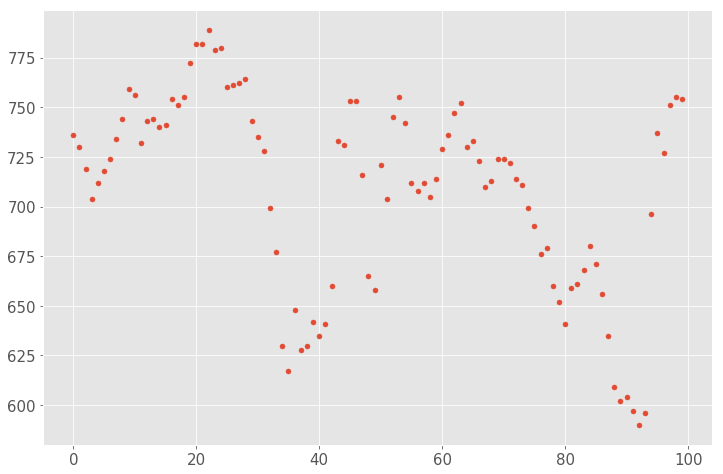

In [13]:
plt.figure(figsize=(12,8))
plt.scatter(np.arange(100), y = NNIntervals[:100])

# Lomb method
> Test de 3 différentes manière de calculer la PSD avec la méthode Lomb. Uniquement avec la librairie astropy. A noter qu'il est possible d'utiliser scipy.signal.

{'LF': 382.5306931124769,
 'HF': 131.2905904393458,
 'LF_HR_ratio': 2.9136184994856893,
 'LFnu': 74.44819927820211,
 'HFnu': 25.551800721797886,
 'total_power': 976.7404960649994,
 'VLF': 462.9192125131768}

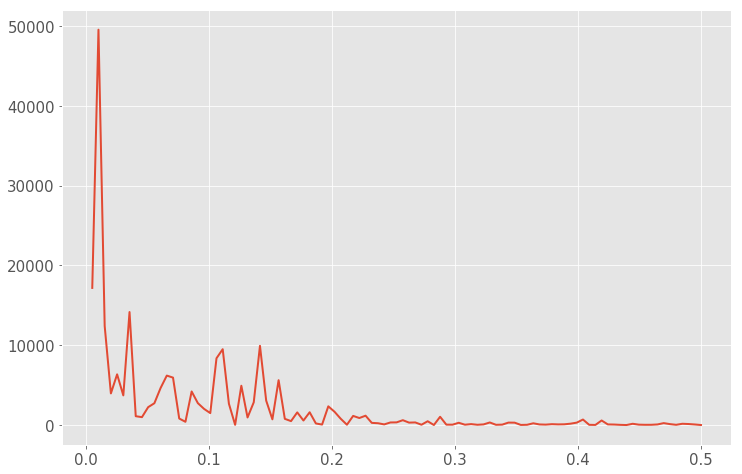

In [14]:
from astropy.stats import LombScargle

t = np.cumsum(NNIntervals)/1000
y = NNIntervals
# 100 points pour la fréquence, possible d'augmenter pour + de précision
freq = np.linspace(0, 0.5, 100)
power = LombScargle(t, y, normalization='psd').power(freq)

# Plot
plt.figure(figsize=(12,8))
plt.plot(freq, power)
get_features_from_PSD(freq, power)

1795


/Users/robinchampseix/Desktop/stage/features_engineering/venv/lib/python3.7/site-packages/astropy/stats/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in true_divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


{'LF': 403.7893740370663,
 'HF': 139.97822941135587,
 'LF_HR_ratio': 2.8846583910591206,
 'LFnu': 74.25771073457612,
 'HFnu': 25.742289265423878,
 'total_power': 1227.3197846070223,
 'VLF': 683.5521811586}

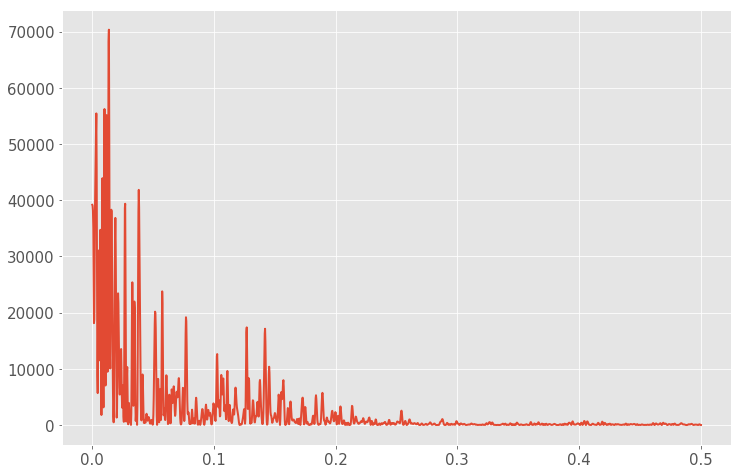

In [15]:
# autopower + précis, ajuste automatiquement le nombre de points pour la fréquence de restitution
frequency, power = LombScargle(t, y, normalization='psd').autopower(minimum_frequency=0, 
                                                                    maximum_frequency=0.5)

print(len(frequency))
#Plot 
plt.figure(figsize=(12,8))
plt.plot(frequency, power)
get_features_from_PSD(frequency, power)

# Fourier's Method

499


{'LF': 372.49388933883944,
 'HF': 120.93123634558012,
 'LF_HR_ratio': 3.08021236361447,
 'LFnu': 75.49147174501117,
 'HFnu': 24.508528254988832,
 'total_power': 1129.4519766081366,
 'VLF': 636.0268509237171}

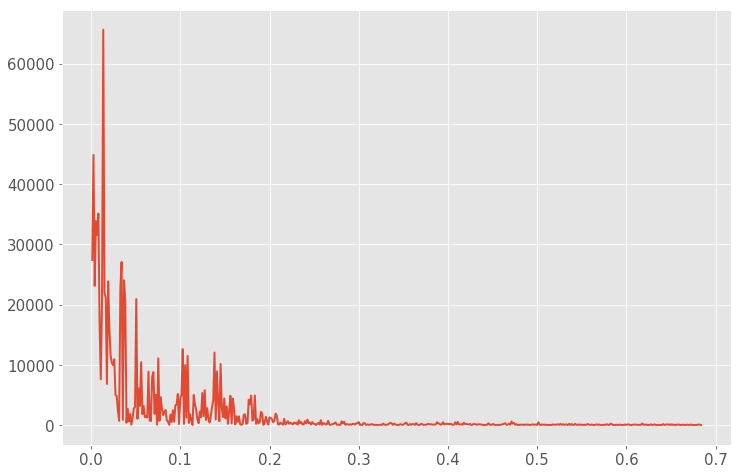

In [16]:
def fourier_periodogram(t, y):
    N = len(t)
    # Return the Discrete Fourier Transform sample frequencies
    frequency = np.fft.fftfreq(N, t[1] - t[0])
    # Compute the one-dimensional discrete Fourier Transform
    y_fft = np.fft.fft(y)
    positive = (frequency > 0)
    return frequency[positive], (1. / N) * abs(y_fft[positive]) ** 2

frequency, PSD_fourier = fourier_periodogram(t, y)
print(len(frequency))
# Plot
plt.figure(figsize=(12,8))
plt.plot(frequency, PSD_fourier)
get_features_from_PSD(frequency, PSD_fourier)

{'LF': 397.08300300585364,
 'HF': 139.22801804010302,
 'LF_HR_ratio': 2.852033725650526,
 'LFnu': 74.03968731267737,
 'HFnu': 25.960312687322627,
 'total_power': 1182.1621981136805,
 'VLF': 645.8511770677237}

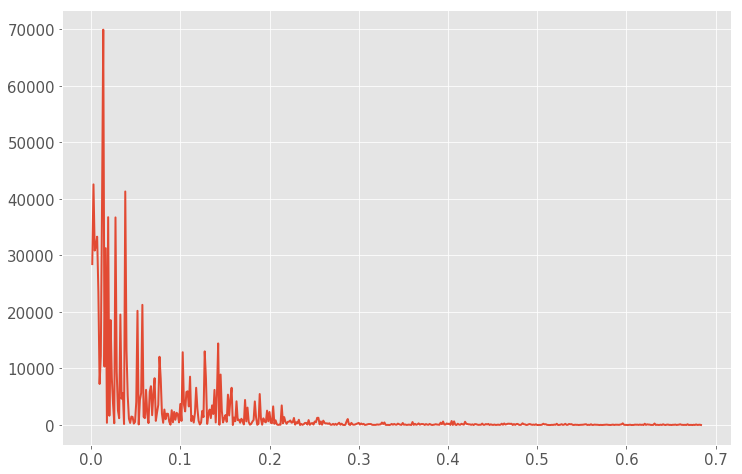

In [17]:
PSD_LS = LombScargle(t, y).power(frequency, normalization='psd')

# Plot
plt.figure(figsize=(12,8))
plt.plot(frequency, PSD_LS)
get_features_from_PSD(frequency, PSD_LS)

# Welch's Method

##  Interpolation du signal

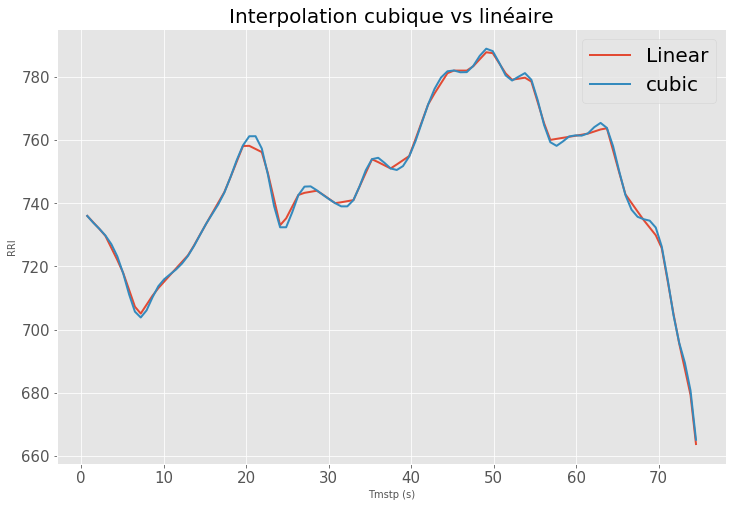

In [18]:
# ---------- Interpolation du signal linéaire ---------- #

timestamps = create_time_info(NNIntervals)
function = interpolate.interp1d(x = timestamps, y = NNIntervals, 
                             kind = 'linear')
    
timestamps_interpolation = create_interpolation_time(NNIntervals, 
                                                     sampling_frequency = 4)
NNI_interpolation_linear = function(timestamps_interpolation)

# ---------- Interpolation du signal cubique ---------- #

timestamps = create_time_info(NNIntervals)
function = interpolate.interp1d(x = timestamps, y = NNIntervals, 
                             kind = 'cubic')
    
timestamps_interpolation = create_interpolation_time(NNIntervals, 
                                                     sampling_frequency = 4)
NNI_interpolation_cubic = function(timestamps_interpolation)

# ---------- Plot ---------- #
y = np.cumsum(NNI_interpolation_cubic[:100])/1000
plt.figure(figsize=(12,8))
plt.title("Interpolation cubique vs linéaire")
# Only 100 first points as an exemple
plt.plot(y, NNI_interpolation_linear[:100], label = "Linear")
plt.plot(y, NNI_interpolation_cubic[:100], label = "cubic")
plt.ylabel('RRI')
plt.xlabel('Tmstp (s)')
plt.legend(loc = "best")
plt.show()

# Calcul de la PSD - FFT / Welch

In [19]:
#  ---------- Removing DC Component ---------- #
RRseries = NNI_interpolation_linear - np.mean(NNI_interpolation_linear)

from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "image.png", width=600, height=600)

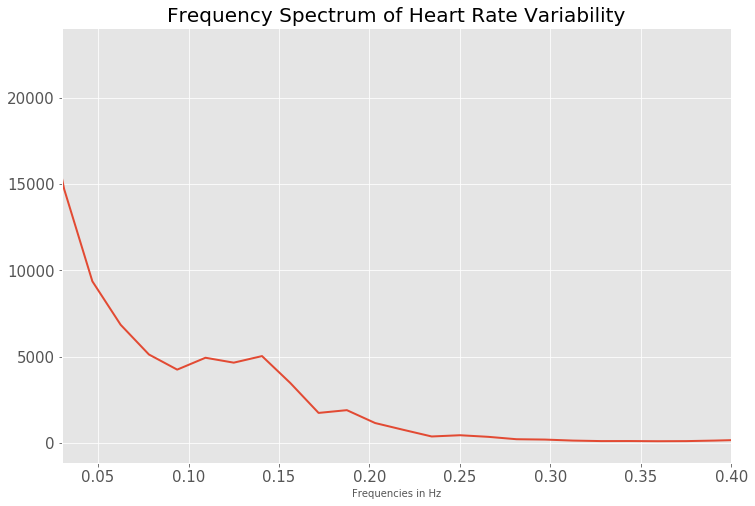

In [20]:
#  ----------  Calcul PSD  ---------- #
fs = 4
n = 300* fs
freq, Pxx = signal.welch(x = RRseries, fs = fs, window = 'hann')

#Plot
plt.figure(figsize=(12,8))
plt.title("Frequency Spectrum of Heart Rate Variability")
plt.xlim(0.03, 0.4) 
# For visibility
plt.plot(freq, abs(Pxx)) 
plt.xlabel("Frequencies in Hz")
plt.show()

In [21]:
get_frequency_domain_features(NNIntervals, sampling_frequency = 4)

{'LF': 516.1366187291716,
 'HF': 149.72793727263465,
 'LF_HR_ratio': 3.447163088805234,
 'LFnu': 77.51375472338124,
 'HFnu': 22.486245276618764,
 'total_power': 959.7916707672306,
 'VLF': 293.9271147654243}

In [22]:
Image(url= "psd.png", width=600, height=600)

# Non Linear Domain Features

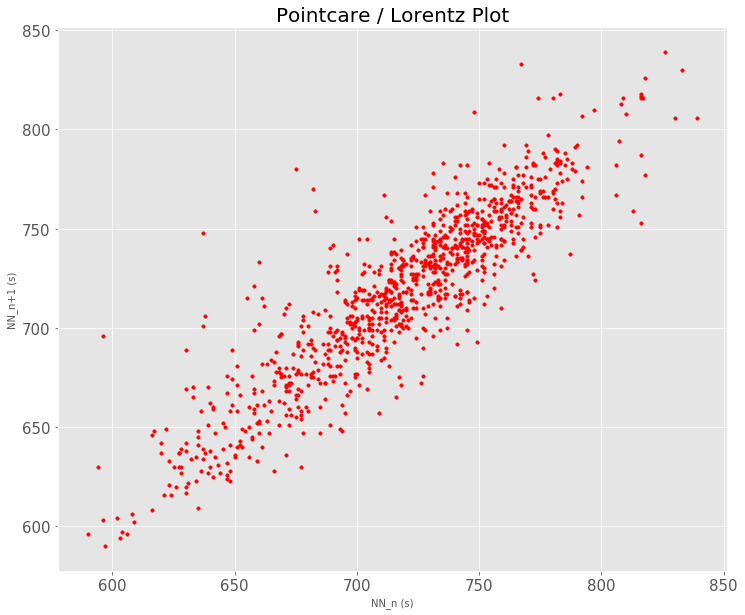

In [23]:
def plotPoincare(NNIntervals):
    """
    Plot the Pointcare / Lorentz Plot
    
    Arguments
    ---------
    NNIntervals - list of NN intervals
        
    Returns
    ---------
    Poincare plot  

    Notes
    ---------
    The transverse axis (T) reflects beat-to-beat variation
    the longitudinal axis (L) reflects the overall fluctuation
    """
    ax1 = NNIntervals[:-1]
    ax2 = NNIntervals[1:]   
    
    plt.figure(figsize=(12,10))
    plt.title("Pointcare / Lorentz Plot", )
    plt.scatter(ax1, ax2, c = 'r', s = 12)
    plt.xlabel('NN_n (s)')
    plt.ylabel('NN_n+1 (s)')
    plt.show()
    
plotPoincare(NNIntervals)

In [24]:
Image(url= "pointcareplot.png", 
      width=800, height=800)

In [25]:
def get_csi_cvi_features(NNIntervals):
    """
    Function returning a dictionnary containing 3 features from non linear domain  
    for HRV analyses.
    Must use this function on short term recordings, for 30 , 50, 100 Rr Intervals 
    or seconds window.

    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval

    Returns
    ---------
    csi_cvi_features - dictionnary containing non linear domain features 
    for HRV analyses. Thera are details about each features are given below. 
    
    Notes
    ---------
    - **CSI** : 
    - **CVI** : 
    - **Modified_CSI** : 
    
    References
    ----------
    TO DO    
    """
    
    # Measures the width and length of poincare cloud
    poincare_plot_features = get_poincare_plot_features(NNIntervals)
    T = 4 * poincare_plot_features['SD1']
    L = 4 * poincare_plot_features['SD2']
    
    CSI = L / T
    CVI = np.log10(L * T)
    Modified_CSI = L**2 / T
    
    csi_cvi_features = {
        'CSI' : CSI,
        'CVI' : CVI,
        'Modified_CSI' : Modified_CSI
    }
    
    return csi_cvi_features

def get_poincare_plot_features(NNIntervals):
    """
    Function returning a dictionnary containing 3 features from non linear domain  
    for HRV analyses.
    Must use this function on short term recordings, from 5 minutes window.

    Arguments
    ---------
    NNIntervals - list of Normal to Normal Interval

    Returns
    ---------
    poincare_plot_features - dictionnary containing non linear domain features 
    for HRV analyses. Thera are details about each features are given below. 
    
    Notes
    ---------
    - **SD1** : 
    - **SD2** : 
    - **ratio_SD1_SD2** : 
    
    References
    ----------
    TO DO   
    """
    diff_NNIntervals = np.diff(NNIntervals)
    # measures the width of poincare cloud
    SD1 = np.sqrt(np.std(diff_NNIntervals, ddof=1) ** 2 * 0.5)
    # measures the length of the poincare cloud
    SD2 = np.sqrt(2 * np.std(NNIntervals, ddof=1) ** 2 - 0.5 * np.std(diff_NNIntervals,
                                                              ddof=1) ** 2)
    ratio_SD1_SD2 = SD1 / SD2
    
    poincare_plot_features = {
        'SD1' : SD1,
        'SD2' : SD2,
        'ratio_SD1_SD2' : ratio_SD1_SD2
    }

    return poincare_plot_features

def get_sampen(NNIntervals):
    """
    Must use this function on short term recordings, from 1 minute window.
    TO DO
    """
    SampEn = nolds.sampen(NNIntervals, emb_dim = 2)
    return {'Sampen' : SampEn}

In [26]:
print(get_csi_cvi_features(NNIntervals))
print()
print(get_poincare_plot_features(NNIntervals))
print()
print(get_sampen(NNIntervals))

{'CSI': 4.300520404060338, 'CVI': 4.117977429005704, 'Modified_CSI': 1021.5749458778378}

{'SD1': 13.80919037557993, 'SD2': 59.38670497373513, 'ratio_SD1_SD2': 0.2325299977779084}

{'Sampen': 1.2046675751816824}
